# Electric Vehicle in Washington State: 3. Prediction (Regression)

In [1]:
import pickle
import joblib
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import streamlit as st
import shap

from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFECV

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, KFold, cross_val_score

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, HuberRegressor, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [3]:
from IPython.display import display, HTML

def print_all(df): 
    with pd.option_context('display.max_rows',None):
        with pd.option_context('display.max_columns',None):
            with pd.option_context('display.float_format', '{:,.4f}'.format):
                with pd.option_context('display.float_format', '{:,.4f}'.format): # 셀 안의 내용 전체 출력
                    print(df.shape)
                    display(df)

def print_cols(df, n=5): 
    with pd.option_context('display.max_columns',None):
        with pd.option_context('display.float_format', '{:,.4f}'.format):
            print(df.shape)
            display(df[:n])

# Data Load

In [4]:
def load_data():
    with open('data_processed/ev.pickle', 'rb') as f:
        ev = pickle.load(f)
    with open('data_processed/ev_merged.pickle', 'rb') as f:
        ev_merged = pickle.load(f)
    with open('data_processed/ev_state.pickle', 'rb') as f:
        ev_state = pickle.load(f)
    return ev, ev_merged, ev_state

ev, ev_merged, ev_state = load_data()

print_cols(ev_merged, 2)
print_cols(ev, 2)
print_cols(ev_state, 2)

(49, 41)


,legislative_district,ev_count,registered_voters,ballots_cast,%_turnout,dem_votes,rep_votes,party_won,charger_count,geoid,median_household_income,margin_error,shape_leng,shape_le_1,shape_area,shape__area,shape__length,voters_18_24,voters_25_34,voters_35_44,voters_45_54,voters_55_64,voters_over_65,total_active_voters,charger_density,charger_density__area,charger_density_leng,charger_density_le_1,charger_density__length,charger_per_voter_total,charger_per_voter_18_24,charger_per_voter_25_34,charger_per_voter_35_44,charger_per_voter_45_54,charger_per_voter_55_64,charger_per_voter_over_65,charger_ev_ratio,transformed_ev_count,transformed_charger_count,transformed_charger_ev_ratio,transformed_charger_density
0,41,12994,98278,65840,0.6699,45730,19526,Democratic,53,61000US53041,176908,4036,1.0598,"306,763.8140","1,667,039,196.5100","340,035,312.1016","138,532.7913",12155,13133,14562,19484,17576,23704,100614,0.0000,0.0000,50.0099,0.0002,0.0004,0.0005,0.0044,0.0040,0.0036,0.0027,0.0030,0.0022,0.0041,113.9912,7.2801,0.0639,0.0002
1,45,12003,96577,67381,0.6977,46385,20531,Democratic,29,61000US53045,162491,5810,1.4077,"409,524.5479","2,890,039,170.5800","592,170,747.9688","185,351.7548",10756,13852,17273,19538,16140,22119,99678,0.0000,0.0000,20.6017,0.0001,0.0002,0.0003,0.0027,0.0021,0.0017,0.0015,0.0018,0.0013,0.0024,109.5582,5.3852,0.0492,0.0001


(204997, 17)


,vin,county,city,state,postal_code,model_year,make,model,ev_type,cafv_eligibility,electric_range,base_msrp,legislative_district,dol_vehicle_id,vehicle_location,electric_utility,2020_census_tract
0,JTMAB3FV3P,Kitsap,Seabeck,WA,98380,2023,TOYOTA,RAV4 PRIME,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,42.0000,0.0000,35,240684006,POINT (-122.8728334 47.5798304),PUGET SOUND ENERGY INC,53035091301
1,1N4AZ1CP6J,Kitsap,Bremerton,WA,98312,2018,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,151.0000,0.0000,35,474183811,POINT (-122.6961203 47.5759584),PUGET SOUND ENERGY INC,53035080700


(51, 2)


,state,registration_count
0,California,1256646
1,Florida,254878


In [7]:
ev_merged.columns.tolist()

['legislative_district',
 'ev_count',
 'registered_voters',
 'ballots_cast',
 '%_turnout',
 'dem_votes',
 'rep_votes',
 'party_won',
 'charger_count',
 'geoid',
 'median_household_income',
 'margin_error',
 'shape_leng',
 'shape_le_1',
 'shape_area',
 'shape__area',
 'shape__length',
 'voters_18_24',
 'voters_25_34',
 'voters_35_44',
 'voters_45_54',
 'voters_55_64',
 'voters_over_65',
 'total_active_voters',
 'charger_density',
 'charger_density__area',
 'charger_density_leng',
 'charger_density_le_1',
 'charger_density__length',
 'charger_per_voter_total',
 'charger_per_voter_18_24',
 'charger_per_voter_25_34',
 'charger_per_voter_35_44',
 'charger_per_voter_45_54',
 'charger_per_voter_55_64',
 'charger_per_voter_over_65',
 'charger_ev_ratio',
 'transformed_ev_count',
 'transformed_charger_count',
 'transformed_charger_ev_ratio',
 'transformed_charger_density']

Target variable
- ev_count

EV Count 분포 통계:
min: 537.00
max: 12994.00
mean: 4183.61
median: 3045.00
25%: 2004.00
75%: 5508.00
Skewness: 1.2624551870982634
Kurtosis: 1.0520433149809016


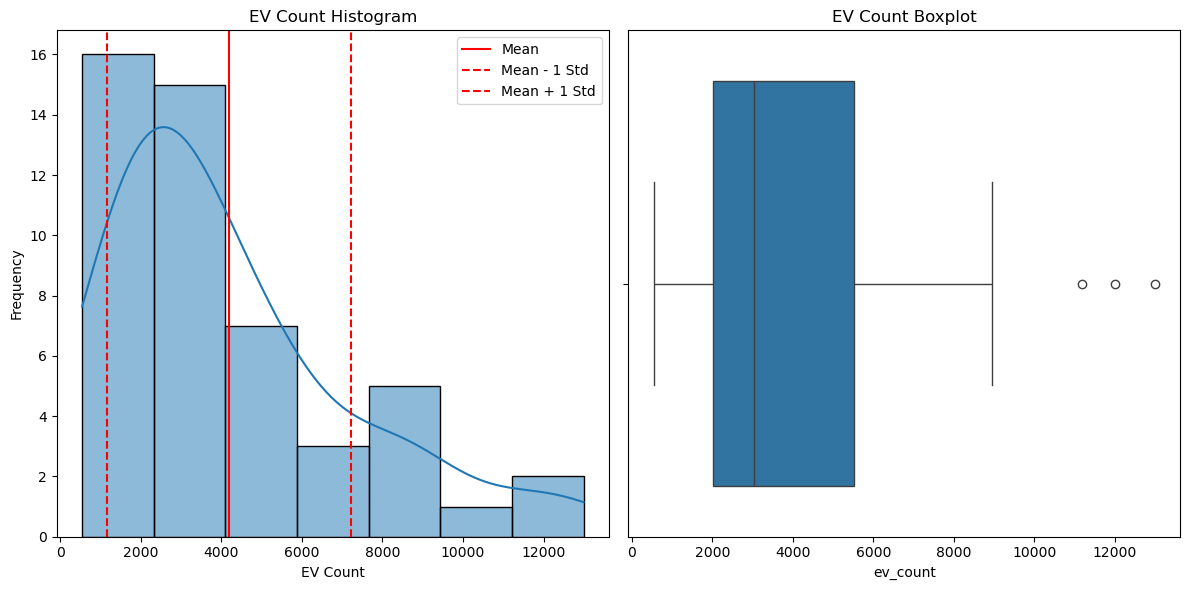

In [39]:
# Visualizing target column distribution
# Determine the best method for categorization and class labeling by checking the distribution

# EV count data from the dataset
ev_count = ev_merged['ev_count']

# Basic statistics for EV count
stats = {
    'min': ev_count.min(),
    'max': ev_count.max(),
    'mean': ev_count.mean(),
    'median': ev_count.median(),
    '25%': ev_count.quantile(0.25),
    '75%': ev_count.quantile(0.75)
}
print("EV Count 분포 통계:") # Distribution Statistics
for key, value in stats.items():
    print(f"{key}: {value:.2f}")

# Plot 1: Data distribution visualization (Histogram)
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.histplot(ev_count, kde=True)
plt.title('EV Count Histogram')
plt.xlabel('EV Count')
plt.ylabel('Frequency')

# Highlight boundaries based on normal distribution
mean, std = ev_count.mean(), ev_count.std()
plt.axvline(mean, color='r', linestyle='-', label='Mean')
plt.axvline(mean - std, color='r', linestyle='--', label='Mean - 1 Std')
plt.axvline(mean + std, color='r', linestyle='--', label='Mean + 1 Std')
plt.legend()

# Check skewness and kurtosis
print("Skewness:", ev_count.skew())
print("Kurtosis:", ev_count.kurtosis())

# Plot 2: Data distribution visualization (Boxplot)
plt.subplot(122)
sns.boxplot(x=ev_count)
plt.title('EV Count Boxplot')

plt.tight_layout()
plt.show()

Right-Skewed Distribution
- Many small values and a few large values.  
- The data is concentrated near smaller values close to 0, with some extreme large values creating a long tail to the right.  

Correlations

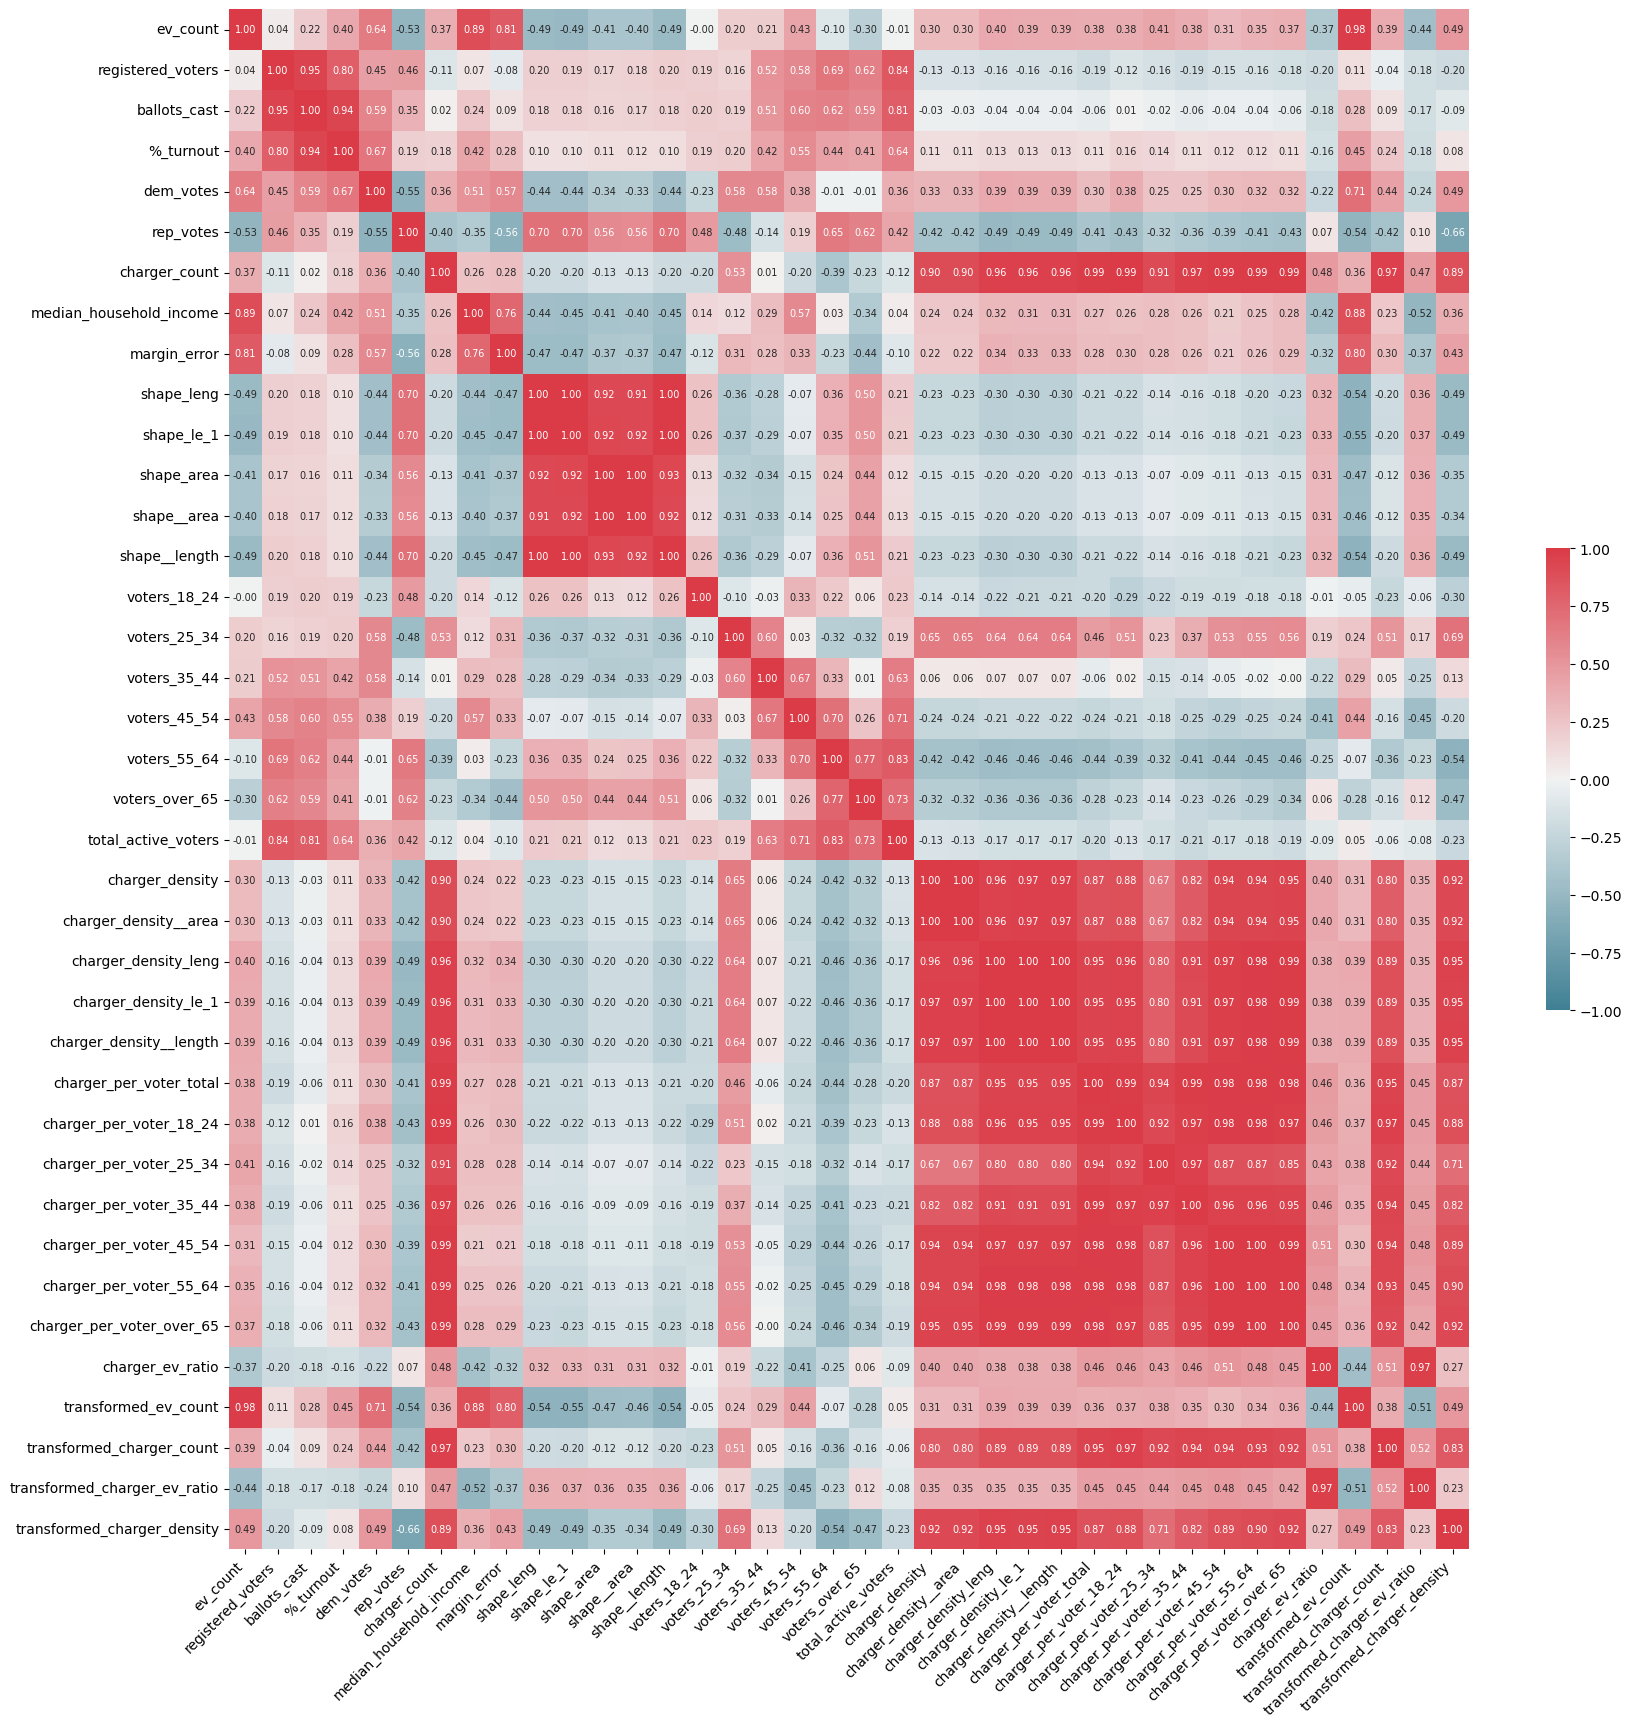

In [276]:
def get_corr_heatmap(df, title=''):
    my_colormap = sns.diverging_palette(220, 10, as_cmap=True) # custom diverging colormap
    plt.figure(figsize=(20, 20))
    corr_matrix = df.corr(numeric_only=True)
    sns.heatmap(corr_matrix, annot=True, annot_kws={'size': 7}, cmap=my_colormap, fmt='.2f', vmin=-1, vmax=1, cbar_kws={'shrink': 0.3})
    plt.xticks(rotation=45, ha='right')
    # plt.tick_params(axis='x', bottom=False, labelbottom=False)
    plt.title(title)
    plt.show()

get_corr_heatmap(ev_merged)

# Data Split
- Feature selection and adjustment of the variable list to use for modeling included

In [292]:
cols_exlucde = ['legislative_district','ev_count','geoid','party_won_encoded','charger_ev_ratio','charger_density_per_100']
# cols_exlucde = cols_exlucde + ['margin_error']
cols_exlucde = cols_exlucde + ['avg_electric_range', 'median_electric_range', 'avg_base_msrp', 'median_base_msrp', 'avg_model_year', 'median_model_year']

cols_use = [col for col in ev_merged.columns if col not in cols_exlucde and 'transformed' not in col]
X = ev_merged[cols_use].copy()
y = ev_merged['ev_count'].copy()

# split data into training and testing sets for model development
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print_cols(X_train, 1)

(39, 33) (10, 33) (39,) (10,)
(39, 33)


,registered_voters,ballots_cast,%_turnout,dem_votes,rep_votes,party_won,charger_count,median_household_income,margin_error,shape_leng,shape_le_1,shape_area,shape__area,shape__length,voters_18_24,voters_25_34,voters_35_44,voters_45_54,voters_55_64,voters_over_65,total_active_voters,charger_density,charger_density__area,charger_density_leng,charger_density_le_1,charger_density__length,charger_per_voter_total,charger_per_voter_18_24,charger_per_voter_25_34,charger_per_voter_35_44,charger_per_voter_45_54,charger_per_voter_55_64,charger_per_voter_over_65
17,108351,77868,0.7187,52061,25073,Democratic,74,81613,1998,4.1369,"1,183,471.0930","28,060,537,071.3000","5,944,257,622.1797","544,549.3004",11958,16180,16635,14670,16054,37378,112875,0.0000,0.0000,17.8879,0.0001,0.0001,0.0007,0.0062,0.0046,0.0044,0.0050,0.0046,0.0020


In [278]:
[col for col in X_train.columns.tolist() if col != 'party_won']

['registered_voters',
 'ballots_cast',
 '%_turnout',
 'dem_votes',
 'rep_votes',
 'charger_count',
 'median_household_income',
 'margin_error',
 'shape_leng',
 'shape_le_1',
 'shape_area',
 'shape__area',
 'shape__length',
 'voters_18_24',
 'voters_25_34',
 'voters_35_44',
 'voters_45_54',
 'voters_55_64',
 'voters_over_65',
 'total_active_voters',
 'charger_density',
 'charger_density__area',
 'charger_density_leng',
 'charger_density_le_1',
 'charger_density__length',
 'charger_per_voter_total',
 'charger_per_voter_18_24',
 'charger_per_voter_25_34',
 'charger_per_voter_35_44',
 'charger_per_voter_45_54',
 'charger_per_voter_55_64',
 'charger_per_voter_over_65']

# Encoding/Scaling

In [301]:
# numeric features
num_cols = [col for col in X_train.columns.tolist() if col != 'party_won']

# categorical features
cat_cols = ['party_won']
oh_cols = []
lb_cols = ['party_won']

# Imputation and Encoding pipeline
# 1. SimpleImputer will handle missing values
# 2. OneHotEncoder and OrdinalEncoder will handle encoding

preprocessor = ColumnTransformer(
    transformers = [
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')), # handle missing values for numeric columns
            ('scaler', StandardScaler()) # standardize numeric features
        ]), num_cols),
        ('oh', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')), # fill missing categorical data with the most frequent value
            # ('encoder', OneHotEncoder(drop='first', handle_unknown='error')) # one-hot encode categorical features
            ('encoder', OneHotEncoder(handle_unknown='error'))
        ]), oh_cols),
        ('lb', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')), # handle missing categorical data
            ('encoder', OrdinalEncoder(handle_unknown='error')) # ordinal encode
        ]), lb_cols)
    ], remainder='passthrough'
)

# Transform the training and test data
X_train_enc = preprocessor.fit_transform(X_train)
X_test_enc = preprocessor.transform(X_test)

col_names_prep = preprocessor.get_feature_names_out()
# col_names_prep = [col.split('__')[1] for col in col_names_prep]
col_names_prep = [col.replace('num__', '').replace('lb__', '') for col in col_names_prep]

X_train_enc = pd.DataFrame(X_train_enc, columns=col_names_prep)
X_test_enc = pd.DataFrame(X_test_enc, columns=col_names_prep)

print_cols(X_train_enc, 2)
print_cols(X_test_enc, 2)

(39, 33)


,registered_voters,ballots_cast,%_turnout,dem_votes,rep_votes,charger_count,median_household_income,margin_error,shape_leng,shape_le_1,shape_area,shape__area,shape__length,voters_18_24,voters_25_34,voters_35_44,voters_45_54,voters_55_64,voters_over_65,total_active_voters,charger_density,charger_density__area,charger_density_leng,charger_density_le_1,charger_density__length,charger_per_voter_total,charger_per_voter_18_24,charger_per_voter_25_34,charger_per_voter_35_44,charger_per_voter_45_54,charger_per_voter_55_64,charger_per_voter_over_65,party_won
0,0.8529,1.1801,1.2093,1.1843,-0.1772,0.1826,-0.4347,-0.8871,0.2237,0.2015,-0.2410,-0.2239,0.2287,1.7378,-0.2251,-0.4162,-0.3332,0.0455,1.4138,0.8533,-0.2888,-0.2901,-0.3165,-0.3079,-0.3106,0.0551,-0.0431,0.3575,0.2089,0.1373,0.0413,-0.1624,0.0000
1,0.0810,0.4973,0.8979,0.9220,-0.5640,-0.2700,1.5072,1.0815,-0.7528,-0.7505,-0.5606,-0.5539,-0.7464,-0.2563,-0.3165,0.8620,0.8194,-0.0692,-0.3848,-0.0127,-0.1313,-0.1328,-0.1643,-0.1658,-0.1671,-0.2661,-0.2697,-0.2402,-0.3287,-0.3081,-0.2552,-0.2279,0.0000


(10, 33)


,registered_voters,ballots_cast,%_turnout,dem_votes,rep_votes,charger_count,median_household_income,margin_error,shape_leng,shape_le_1,shape_area,shape__area,shape__length,voters_18_24,voters_25_34,voters_35_44,voters_45_54,voters_55_64,voters_over_65,total_active_voters,charger_density,charger_density__area,charger_density_leng,charger_density_le_1,charger_density__length,charger_per_voter_total,charger_per_voter_18_24,charger_per_voter_25_34,charger_per_voter_35_44,charger_per_voter_45_54,charger_per_voter_55_64,charger_per_voter_over_65,party_won
0,-0.4433,-0.3540,-0.0857,0.4015,-0.8405,0.3024,-0.3951,-0.1621,-0.8087,-0.8117,-0.5583,-0.5519,-0.8102,-1.3217,0.2588,0.2900,-0.4618,-0.4610,-0.5192,-0.5163,0.0153,0.0191,0.2532,0.2463,0.2503,0.2989,0.4460,0.3660,0.2107,0.2565,0.1864,0.1793,0.0000
1,0.1901,-0.2102,-0.4826,1.3754,-1.8426,-0.3366,0.0603,1.0559,-0.8981,-0.8935,-0.5706,-0.5639,-0.8906,-1.0080,1.6910,1.7040,0.0894,-0.9555,-0.9361,0.0670,0.0341,0.0346,0.0232,-0.0009,-0.0010,-0.3285,-0.2819,-0.5435,-0.4219,-0.3175,-0.2474,-0.2085,0.0000


In [207]:
# import pickle

# with open('data_processed/ev_merged.pickle', 'wb') as f:
#     pickle.dump(ev_merged, f)

# with open('data_processed/ev_merged.pickle', 'rb') as f:
#     ev_merged = pickle.load(f)

# Feature Selection

Feature selection

Considering the small dataset size (n=49) and 14 variables, effective feature selection is necessary to prevent overfitting

Sequentially apply Filter Method and Wrapper Method:

1) Filter Methods:
- F-regression: Captures linear relationships.
- Mutual Information: Captures non-linear relationships
- Select variables with p-value < 0.1 and an average score in the top 50%

2) Wrapper Methods:
- RandomForest and RFECV: Select variables considering non-linear relationships
- LassoCV: Select variables considering linear relationships
- Use the intersection of both methods as the final variables (a more conservative approach)

Visualization and Evaluation:
- Visualize the results of Filter Methods to compare variable importance
- Evaluate performance on the test set using the final selected variables

Since the dataset is small:
- Use 5-fold cross-validation
- Use the intersection of the two Wrapper Methods to prevent overfitting
- Ensure at least 3 variables are selected

1. Applying Filter Methods...


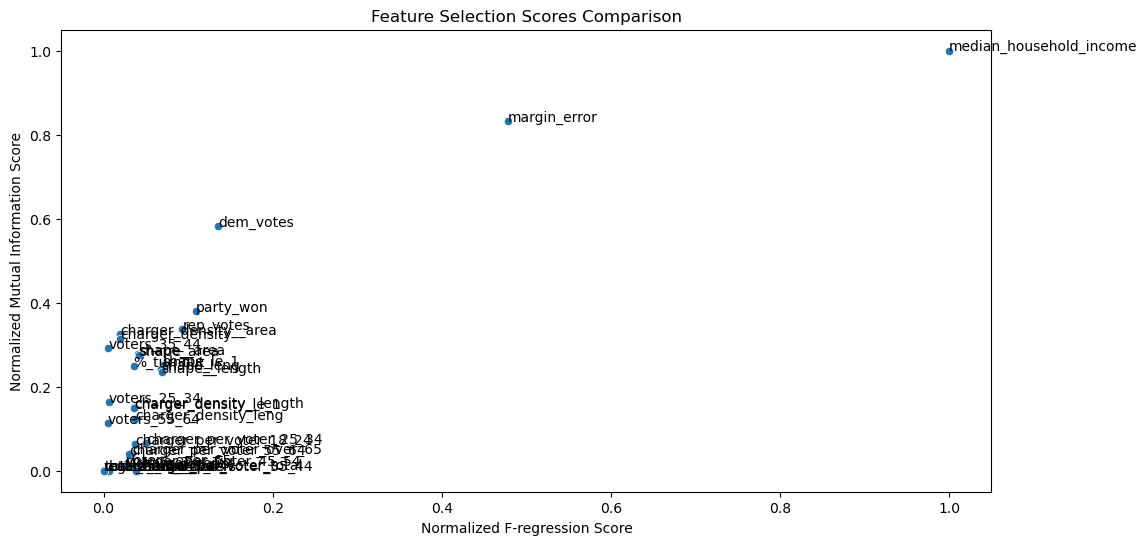


Selected features from Filter Methods: 15
['median_household_income', 'margin_error', 'dem_votes', 'party_won', 'rep_votes', 'charger_density__area', 'charger_density', 'shape_le_1', 'shape__area', 'shape_area', 'shape_leng', 'shape__length', '%_turnout', 'charger_density__length', 'charger_density_le_1']

2. Applying Wrapper Methods...

Final selected features: 3
['median_household_income', 'margin_error', 'dem_votes']

Test R2 Score: 0.3986
Test RMSE: 1160.6092


/opt/miniconda3/envs/cmse830/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42535.0096963197, tolerance: 36065.650621875
  model = cd_fast.enet_coordinate_descent_gram(
/opt/miniconda3/envs/cmse830/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43278.22294072807, tolerance: 36065.650621875
  model = cd_fast.enet_coordinate_descent_gram(
/opt/miniconda3/envs/cmse830/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42888.754756346345, tolerance: 36065.650621875
  model = cd_fast.enet_coordinate_descent_gram(


In [321]:
# Feature Selection

# 1. Filter Methods
def apply_filter_methods(X_train_enc, y_train, X_test_enc):
    """
    두 가지 Filter Method를 적용:
    1. F-regression (linear correlation)
    2. Mutual Information (non-linear relationships)
    """
    X_train_enc = X_train_enc.copy()
    y_train = y_train.copy()
    X_test_enc = X_test_enc.copy()
    
    # F-regression
    f_selector = SelectKBest(score_func=f_regression, k='all')
    f_selector.fit(X_train_enc, y_train)
    f_scores = pd.DataFrame({
        'Feature': X_train_enc.columns,
        'F_Score': f_selector.scores_,
        'F_Pvalue': f_selector.pvalues_
    })
    f_scores = f_scores.sort_values('F_Score', ascending=False)
    
    # Mutual Information
    mi_selector = SelectKBest(score_func=mutual_info_regression, k='all')
    mi_selector.fit(X_train_enc, y_train)
    mi_scores = pd.DataFrame({
        'Feature': X_train_enc.columns,
        'MI_Score': mi_selector.scores_
    })
    mi_scores = mi_scores.sort_values('MI_Score', ascending=False)
    
    # Combine scores and select features
    combined_scores = pd.merge(f_scores, mi_scores, on='Feature')
    
    # Normalize scores to 0-1 range for fair comparison
    combined_scores['F_Score_Norm'] = (combined_scores['F_Score'] - combined_scores['F_Score'].min()) / \
                                    (combined_scores['F_Score'].max() - combined_scores['F_Score'].min())
    combined_scores['MI_Score_Norm'] = (combined_scores['MI_Score'] - combined_scores['MI_Score'].min()) / \
                                     (combined_scores['MI_Score'].max() - combined_scores['MI_Score'].min())
    
    # Calculate average normalized score
    combined_scores['Avg_Score'] = (combined_scores['F_Score_Norm'] + combined_scores['MI_Score_Norm']) / 2
    combined_scores = combined_scores.sort_values('Avg_Score', ascending=False)
    
    # Select features with p-value < 0.1 and top 50% of average scores
    threshold = combined_scores['Avg_Score'].median()
    selected_features = combined_scores[
        (combined_scores['F_Pvalue'] < 0.1) & 
        (combined_scores['Avg_Score'] >= threshold)
    ]['Feature'].tolist()
    
    # Visualize results
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=combined_scores, x='F_Score_Norm', y='MI_Score_Norm')
    for idx, row in combined_scores.iterrows():
        plt.annotate(row['Feature'], (row['F_Score_Norm'], row['MI_Score_Norm']))
    plt.title('Feature Selection Scores Comparison')
    plt.xlabel('Normalized F-regression Score')
    plt.ylabel('Normalized Mutual Information Score')
    plt.show()
    
    return selected_features, combined_scores

# 2. Wrapper Methods
def apply_wrapper_methods(X_train_enc, y_train, X_test_enc, y_test, selected_features):
    """
    두 가지 Wrapper Method를 적용:
    1. RFECV with RandomForest
    2. LassoCV
    """
    X_train_enc = X_train_enc.copy()
    y_train = y_train.copy()
    X_test_enc = X_test_enc.copy()
    y_test = y_test.copy()
    
    # Prepare data with selected features from filter method
    X_train_filtered = X_train_enc[selected_features]
    X_test_filtered = X_test_enc[selected_features]
    
    # 1. RFECV with RandomForest
    rf = RandomForestRegressor(n_estimators=100, random_state=777)
    rfecv = RFECV(
        estimator=rf,
        step=1,
        cv=5,
        scoring='neg_mean_squared_error',
        min_features_to_select=3,
        n_jobs=-1
    )
    rfecv.fit(X_train_filtered, y_train)
    rf_selected_features = X_train_filtered.columns[rfecv.support_].tolist()
    
    # 2. LassoCV
    lasso = LassoCV(cv=5, max_iter=1000, random_state=777)
    lasso.fit(X_train_filtered, y_train)
    lasso_selected_features = X_train_filtered.columns[abs(lasso.coef_) > 1e-5].tolist()
    
    # Get intersection of selected features
    final_features = list(set(rf_selected_features) & set(lasso_selected_features))
    
    # Evaluate performance with final features
    rf_final = RandomForestRegressor(n_estimators=100, random_state=777)
    rf_final.fit(X_train_filtered[final_features], y_train)
    y_pred = rf_final.predict(X_test_filtered[final_features])
    
    test_r2 = r2_score(y_test, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return final_features, test_r2, test_rmse

# Main execution
def run_feature_selection(X_train_enc, y_train, X_test_enc, y_test):
    print("1. Applying Filter Methods...")
    selected_features, combined_scores = apply_filter_methods(X_train_enc, y_train, X_test_enc)
    print(f"\nSelected features from Filter Methods: {len(selected_features)}")
    print(selected_features)
    
    print("\n2. Applying Wrapper Methods...")
    final_features, test_r2, test_rmse = apply_wrapper_methods(
        X_train_enc, y_train, X_test_enc, y_test, selected_features
    )
    print(f"\nFinal selected features: {len(final_features)}")
    print(final_features)
    print(f"\nTest R2 Score: {test_r2:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    
    return final_features, combined_scores

# Execute feature selection
final_features, combined_scores = run_feature_selection(X_train_enc, y_train, X_test_enc, y_test)

In [324]:
# selected features
selected_features = final_features + ['rep_votes', 'charger_density']
print(selected_features)

X_train_selected = X_train_enc[selected_features]
X_test_selected = X_test_enc[selected_features]

print_cols(X_train_selected)

['median_household_income', 'margin_error', 'dem_votes', 'rep_votes', 'charger_density']
(39, 5)


,median_household_income,margin_error,dem_votes,rep_votes,charger_density
0,-0.4347,-0.8871,1.1843,-0.1772,-0.2888
1,1.5072,1.0815,0.9220,-0.5640,-0.1313
2,-0.8920,-0.8058,-0.7593,0.6889,-0.2731
3,2.8913,0.9737,0.7188,-0.6602,-0.0964
4,0.8027,0.3054,1.6367,-1.8840,5.8595


# Modeling and Evaluation

Preliminary/initial modeling and evaluation

In [328]:
print(selected_features)

['median_household_income', 'margin_error', 'dem_votes', 'rep_votes', 'charger_density']


In [325]:
# Define a function to compare model performance
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    return {'RMSE': rmse, 'MAE': mae}

# Linear regression
lin_reg = LinearRegression()
lin_reg_results = evaluate_model(lin_reg, X_train_selected, X_test_selected, y_train, y_test)
print(f"Linear Regression Results: RMSE = {lin_reg_results['RMSE']}, MAE = {lin_reg_results['MAE']}")

# Random Forest
rf = RandomForestRegressor(n_estimators=500, random_state=777)
rf_results = evaluate_model(rf, X_train_selected, X_test_selected, y_train, y_test)
print(f"Random Forest Results: RMSE = {rf_results['RMSE']}, MAE = {rf_results['MAE']}")

# XGBoost
xgb = XGBRegressor(n_estimators=500, random_state=777)
xgb_results = evaluate_model(xgb, X_train_selected, X_test_selected, y_train, y_test)
print(f"XGBoost Results: RMSE = {xgb_results['RMSE']}, MAE = {xgb_results['MAE']}")

# ElasticNet
elastic_net = ElasticNet(random_state=777)
elastic_net_results = evaluate_model(elastic_net, X_train_selected, X_test_selected, y_train, y_test)
print(f"ElasticNet Results: RMSE = {elastic_net_results['RMSE']}, MAE = {elastic_net_results['MAE']}")

# KNN
knn = KNeighborsRegressor(n_neighbors=5)
knn_results = evaluate_model(knn, X_train_selected, X_test_selected, y_train, y_test)
print(f"K-Nearest Neighbors Results: RMSE = {knn_results['RMSE']}, MAE = {knn_results['MAE']}")

# SVR (Support Vector Regression)
svr = SVR(kernel='rbf')  # RBF 커널 사용
svr_results = evaluate_model(svr, X_train_selected, X_test_selected, y_train, y_test)
print(f"Support Vector Regression Results: RMSE = {svr_results['RMSE']}, MAE = {svr_results['MAE']}")

# Gradient Boosting Regressor
gb = GradientBoostingRegressor(n_estimators=500, random_state=777)
gb_results = evaluate_model(gb, X_train_selected, X_test_selected, y_train, y_test)
print(f"Gradient Boosting Results: RMSE = {gb_results['RMSE']}, MAE = {gb_results['MAE']}")

# CatBoost
# Specialized for handling categorical variables
cat = CatBoostRegressor(n_estimators=500, random_state=777, verbose=0)
cat_results = evaluate_model(cat, X_train_selected, X_test_selected, y_train, y_test)
print(f"CatBoost Results: RMSE = {cat_results['RMSE']}, MAE = {cat_results['MAE']}")

# Huber Regressor
# A linear model robust to outliers
huber = HuberRegressor(max_iter=500)
huber_results = evaluate_model(huber, X_train_selected, X_test_selected, y_train, y_test)
print(f"Huber Regression Results: RMSE = {huber_results['RMSE']}, MAE = {huber_results['MAE']}")

# Adaboost
ada = AdaBoostRegressor(n_estimators=500, random_state=777)
ada_results = evaluate_model(ada, X_train_selected, X_test_selected, y_train, y_test)
print(f"AdaBoost Results: RMSE = {ada_results['RMSE']}, MAE = {ada_results['MAE']}")

# Summarize the results of all models in a dictionary
results = {
    'Linear Regression': lin_reg_results,
    'Random Forest': rf_results,
    'XGBoost': xgb_results,
    'ElasticNet': elastic_net_results,
    'K-Nearest Neighbors': knn_results,
    'Support Vector Regression': svr_results,
    'Gradient Boosting': gb_results,
    'CatBoost': cat_results,
    'Huber Regression': huber_results,
    'AdaBoost': ada_results
}

# Compare the performance (RMSE) of each model
best_model_name = min(results, key=lambda k: results[k]['RMSE'])  # RMSE가 가장 낮은 모델 선택
print(f"The best model is: {best_model_name} with RMSE = {results[best_model_name]['RMSE']}")

# Dictionary to retrieve the selected model (matched with the respective model class)
model_dict = {
    'Linear Regression': lin_reg,
    'Random Forest': rf,
    'XGBoost': xgb,
    'ElasticNet': elastic_net,
    'K-Nearest Neighbors': knn,
    'Support Vector Regression': svr,
    'Gradient Boosting': gb,
    'CatBoost': cat,
    'Huber Regression': huber,
    'AdaBoost': ada
}

# The final selected model
best_model = model_dict[best_model_name]

Linear Regression Results: RMSE = 1137.6773306361094, MAE = 932.4178508338042
Random Forest Results: RMSE = 1332.3257858827174, MAE = 1113.5624
XGBoost Results: RMSE = 1411.9190863780768, MAE = 1101.41572265625
ElasticNet Results: RMSE = 1029.974469868273, MAE = 886.3975404744617
K-Nearest Neighbors Results: RMSE = 1123.977663479128, MAE = 874.82
Support Vector Regression Results: RMSE = 1719.7390817967425, MAE = 1385.6346619567703
Gradient Boosting Results: RMSE = 1401.137540686837, MAE = 1180.0007685369992
CatBoost Results: RMSE = 1098.298679902557, MAE = 848.2631772363393
Huber Regression Results: RMSE = 1039.814719192357, MAE = 847.3288063152537
AdaBoost Results: RMSE = 1545.2196964658976, MAE = 1289.4542582417585
The best model is: ElasticNet with RMSE = 1029.974469868273


To evaluate this model's predictive power, analyze from several perspectives:

Considering data characteristics
- The dataset is very small (train: 39 samples, test: 10 samples).
- The values of y_test range between about 1,000 and 6,000.
- In other words, the number of electric vehicle registrations varies significantly by region.
- Predicting such large variability with this small dataset is inherently a challenging task.
- It may be particularly difficult to predict regions with low registrations (e.g., 1,080 cars) and high registrations (e.g., 5,994 cars) simultaneously.

Scale perspective:
- An RMSE of 1,030 means that on average, the predicted values differ from the actual values by about ±1,030 cars.
- An MAE of 886 means that there is an average error of about 886 cars.

Relative error perspective:

In [31]:
test_mean = y_test.mean()
test_std = y_test.std()
cv = test_std / test_mean * 100 # Coefficient of Variation: about 41.43%
cv

41.42769051432573

Coefficient of Variation (CV): 
- approximately 41.42% (high variability).
```
CV < 15%: Low variability (very stable).
15% ≤ CV < 30%: Medium variability.
CV ≥ 30%: High variability.
CV > 50%: Very high variability.
```

Interpretation
- The standard deviation is relatively high compared to the mean value of the data.
- There is significant variation in electric vehicle registrations within the test dataset.
- This highlights the regional imbalance in electric vehicle distribution.
- It indicates the difficulty of model prediction and suggests that such high variability should be considered when evaluating model performance.

In [126]:
# Average relative error rate calculation
mean_y = y_test.mean() # 약 3,808
relative_rmse = (results[best_model_name]['RMSE'] / mean_y) * 100 # About 25.5%
relative_mae = (results[best_model_name]['MAE'] / mean_y) * 100 # About 25.5%

relative_rmse, relative_mae

(25.49418368766534, 19.596129971041954)

Average relative error rate
- This means that the predicted values differ from the actual values by about 19-25% on average.
- With a relative error rate below 20%, the model's current performance (RMSE, MAE) is relatively satisfactory. In this dataset, it is considered quite good.
- Despite high variability, the model shows reasonably good predictive power.

Improvement attempts:
- Create additional variables to enrich the dataset.
- Apply ensemble techniques to improve prediction stability by combining multiple models.
- Explore data augmentation or collect additional data for better representation.
- Use models that capture non-linearity effectively (e.g., Random Forest, XGBoost).
- Perform hyperparameter tuning to optimize model performance.
- Implement k-fold cross-validation for a more robust evaluation.
- Provide confidence intervals for predictions to express uncertainty more clearly.

Since the dataset is small, use cross-validation and bootstrapping to evaluate the model's performance more reliably

Stratified K-Fold Cross-Validation
- train and evaluate models using the entire dataset and a k-fold cross-validation approach

In [221]:
# Stratified K-Fold Cross-Validation
# Evaluate performance using K-Fold on the entire dataset

# Modify function for evaluating model performance
def evaluate_models_with_cv(X, y, models, cv=5):
    # Set up cross-validation
    kf = KFold(n_splits=cv, shuffle=True, random_state=777) # Split data into 5 folds for cross-validation
    
    # Dictionary to store results
    cv_results = {}
    
    for name, model in models.items():
        # Create pipeline (feature scaling + model)
        pipeline = Pipeline([
            # ('scaler', MinMaxScaler()), # Since the entire dataset is used, fit and scale again
            ('regressor', model)
        ])
        
        # Perform cross-validation
        scores = cross_validate(
            pipeline, 
            X, y, 
            cv=kf, 
            scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'],
            return_train_score=False,
            n_jobs=-1
        )
        
        # Save results (convert negative scores to positive)
        # Calculate RMSE (Root Mean Squared Error) and MAE (Mean Absolute Error)
        # Assess model stability by including mean performance and standard deviation
        cv_results[name] = {
            'RMSE_mean': np.sqrt(-scores['test_neg_mean_squared_error']).mean(),
            'RMSE_std': np.sqrt(-scores['test_neg_mean_squared_error']).std(),
            'MAE_mean': -scores['test_neg_mean_absolute_error'].mean(),
            'MAE_std': -scores['test_neg_mean_absolute_error'].std()
        }
    
   # Convert results to DataFrame
    results_df = pd.DataFrame.from_dict(cv_results, orient='index')
    results_df = results_df.sort_values('RMSE_mean')
    
    return results_df

# Create model dictionary
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=500, random_state=777),
    'XGBoost': XGBRegressor(n_estimators=500, random_state=777),
    'ElasticNet': ElasticNet(random_state=777),
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5),
    'Support Vector Regression': SVR(kernel='rbf'),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=500, random_state=777),
    'CatBoost': CatBoostRegressor(n_estimators=500, random_state=777, verbose=0),
    'Huber Regression': HuberRegressor(max_iter=500),
    'AdaBoost': AdaBoostRegressor(n_estimators=500, random_state=777)
}

# Load the entire dataset
# Merge all data and evaluate models
X_combined = pd.concat([X_train_selected, X_test_selected])
y_combined = pd.concat([y_train, y_test])

# Evaluate model performance
cv_results = evaluate_models_with_cv(X_combined, y_combined, models, 5)

# Print results
print("Cross-Validation Results:")
print(cv_results)

# Select the best model
best_model_name = cv_results.index[0]
best_model = models[best_model_name]

print(f"\nThe best model is: {best_model_name} with RMSE_mean = {cv_results.loc[best_model_name]['RMSE_mean']} and MAE_mean = {cv_results.loc[best_model_name]['MAE_mean']}")

Cross-Validation Results:
                             RMSE_mean    RMSE_std     MAE_mean     MAE_std
Gradient Boosting          1055.958502  406.179516   825.692052 -319.296266
Random Forest              1116.332839  437.343420   891.497364 -352.749206
XGBoost                    1154.315520  348.718127   878.140967 -227.899183
CatBoost                   1155.673234  503.351365   843.346228 -370.342049
Huber Regression           1268.344771  412.419761   940.028410 -259.186936
K-Nearest Neighbors        1281.492019  538.764154   930.500889 -296.578453
Linear Regression          1323.399762  381.158973   988.395074 -228.206854
ElasticNet                 1360.877206  479.773548  1015.024747 -259.410179
AdaBoost                   1451.433195  664.145903  1126.321532 -466.834105
Support Vector Regression  3148.809563  770.150554  2336.197946 -522.088323

The best model is: Gradient Boosting with RMSE_mean = 1055.9585023430002 and MAE_mean = 825.6920519983616


Bootstrap sampling for evaluation

In [46]:
# Bootstrap setup
n_iterations = 1000
bootstrap_rmse = []
bootstrap_preds = np.zeros((n_iterations, len(y_test)))

# Bootstrap iterations
for i in range(n_iterations):
    # Resample training data
    X_resampled, y_resampled = resample(X_train_selected, y_train, random_state=i)
    
    # Train the model
    best_model.fit(X_resampled, y_resampled)
    
    # Predict using validation data
    y_pred_bootstrap = best_model.predict(X_test_selected)
    
    # Calculate and store RMSE
    rmse_bootstrap = np.sqrt(mean_squared_error(y_test, y_pred_bootstrap))
    bootstrap_rmse.append(rmse_bootstrap)
    
    # Store predictions for each iteration
    bootstrap_preds[i, :] = y_pred_bootstrap

# Calculate mean and standard deviation of RMSE
bootstrap_rmse_mean = np.mean(bootstrap_rmse)
bootstrap_rmse_std = np.std(bootstrap_rmse)

print(f"Bootstrap RMSE: {bootstrap_rmse_mean} ± {bootstrap_rmse_std}")

# Confidence interval calculation (95% confidence interval)
bootstrap_mean = np.mean(bootstrap_preds, axis=0)
bootstrap_ci_lower = np.percentile(bootstrap_preds, 2.5, axis=0)
bootstrap_ci_upper = np.percentile(bootstrap_preds, 97.5, axis=0)

print(f"Bootstrap Mean Prediction: {bootstrap_mean}")
print(f"95% Confidence Interval: [{bootstrap_ci_lower}, {bootstrap_ci_upper}]")

Cross-Validated RMSE: 1386.4210128447814
Bootstrap RMSE: 1191.8406064178519 ± 97.35748856634959
Bootstrap Mean Prediction: [3837.4439977  5639.28253195 3808.80563624 5125.72034072 4644.19775433
 3950.34532556 3394.86084275 6634.06166308 3952.87847496 2161.1634838 ]
95% Confidence Interval: [[3437.65692795 5006.69715647 3350.69126869 4523.33279098 4146.53026797
 3473.69155555 3029.56873583 5550.93061542 3313.611997   1863.8076884 ], [4258.80609066 6226.46206692 4246.97979385 5621.62561827 5172.19144076
 4418.85170951 3821.47406058 7512.52484797 4670.08402964 2531.10619658]]


After training and evaluating the best model (Gradient Boosting Regressor) on the entire dataset, save the final trained model for future use

In [327]:
# Load the entire dataset
X = ev_merged[selected_features].copy() # Filter by selected features
y = ev_merged['ev_count'].copy()

# Evaluate performance on the entire dataset
model = GradientBoostingRegressor(n_estimators=500, random_state=777)
scaler = StandardScaler()

# Final model training: Use the entire dataset
X_scaled = scaler.fit_transform(X) # Fit StandardScaler to the entire dataset
model.fit(X_scaled, y) # Train the final model using the entire dataset

# Save the model and scaler
with open('final_model.pkl', 'wb') as f:
    pickle.dump({'model': model, 'scaler': scaler, 'selected_features': selected_features}, f)

In [ ]:
# Testing for future use
# Load model and scaler
with open('final_model.pkl', 'rb') as f:
    loaded_data = pickle.load(f)
    model = loaded_data['model']
    scaler = loaded_data['scaler']

# Process user input
input_data = pd.DataFrame({
    'median_household_income': [income],
    'dem_votes': [dem_votes],
    'margin_error': [ev_merged['margin_error'].mean()]
})

# Perform prediction
scaled_input = scaler.transform(input_data)
prediction = model.predict(scaled_input)

# st.write(f"Predicted EV Count: {prediction[0]:.2f}")

SHAP Force Plot
- To explain features' impact on the target variable

                  Variable   SHAP Value
1             margin_error  5125.705403
0  median_household_income  2819.049400
2                dem_votes   865.624715


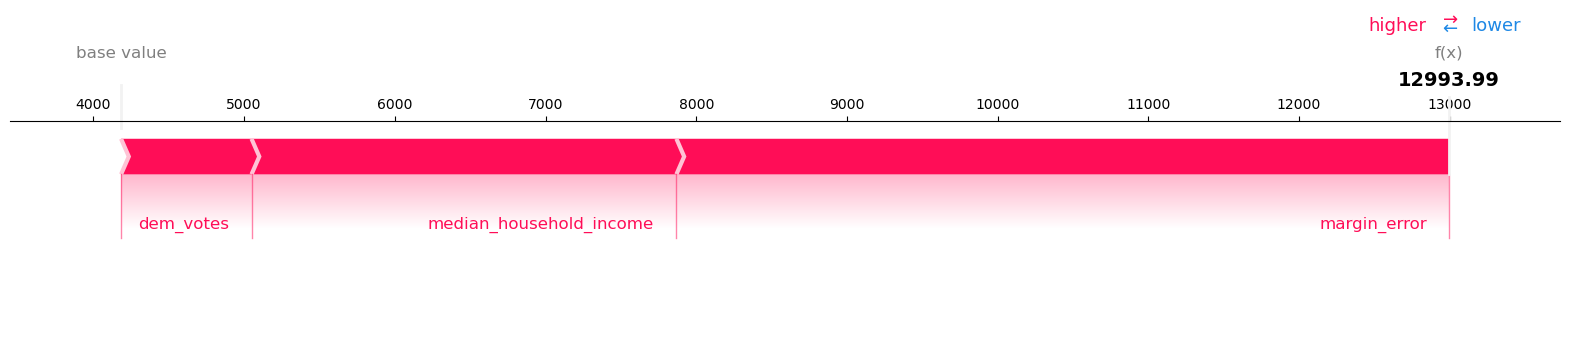

In [252]:
# Initialize SHAP interpreter
explainer = shap.Explainer(model, feature_names=selected_features)

# Calculate SHAP values
shap_values = explainer(X_scaled)

# SHAP Summary Plot
# st.write("### Variable Impact Analysis (SHAP Values)")
shap_table = pd.DataFrame({
    'Variable': selected_features,
    'SHAP Value': shap_values.values[0]
}).sort_values(by='SHAP Value', ascending=False)

# st.table(shap_table)
print(shap_table)

# SHAP Force Plot (Provides a visual summary)
# st.write("### SHAP Force Plot")
shap.force_plot(explainer.expected_value, shap_values.values[0], feature_names=selected_features, matplotlib=True)

# Streamlit

What I need in Streamlit:
1) Scaling/encoding preprocessor
    - Rescaling based on changing input values
2) Trained model
3) Predict

In [340]:
!conda list matplotlib

# packages in environment at /opt/miniconda3/envs/cmse830:
#
# Name                    Version                   Build  Channel
matplotlib                3.9.3           py312h1f38498_0    conda-forge
matplotlib-base           3.9.3           py312hdbc7e53_0    conda-forge
matplotlib-inline         0.1.7              pyhd8ed1ab_0    conda-forge
